## SAR Asymmetries

TODO

- Find the correct filters

- Kepert model will fail when the validity area is too small (e.g Goni)... Why? Add that to filters? In fact, if the validity area is too small, the radii inside the validity area are affected by the large gradients at the edges of the area. Analytically, the BL depth delta-1 becomes infinite, at a rate 1 / sqrt(I - V/r), when I ~ V/r.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [3]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/results/sar_extended/03_addIBT/dsg.nc',
    'sar_dir':  '/home/arthur/data/cyclobs/RCM/sar_files/',
    'sav_dir': '/home/arthur/results/winddirection/00_plotSARasymmetries/',
}

In [4]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# # Open data
# all_data = glob.glob(PTHS['sar_dir'] + "*.nc")
# print('Nb of SAR files = {}'.format(len(all_data)))

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
# all_data = ['/home/arthur/data/cyclobs/RCM/sar_files/rs2--owi-ca-20201030t211604-20201030t211719-00003-______sw_wp222020_cyclone_polar.nc']
# all_data = ['/home/arthur/data/cyclobs/RCM/sar_files/rcm1--owi-ca-20230809t050027-20230809t050143-00003-______sw_ep052023_cyclone_polar.nc']

In [6]:
### FILTERS
# TODO: Remove Southern Hemisphere storms? 
filters = {
    'correct_center': (dsg.center_quality_flag < 2),
    'uncropped'     : (dsg.percent_outside < 5),
    'tropical_lat'  : (abs(dsg.lat) < 30),
    'strong_storm'  : (dsg.vmx >= 33),
    'small_rmx'     : (dsg.rmx <= 100000),
    'far_from_coast': (dsg.dist2coast >= dsg.r0),   
}

kept_storms = np.logical_and.reduce([filters[e] for e in filters.keys()])
dsg['keep'] = xr.DataArray(
    data=kept_storms,
    coords={'time': dsg.time}
)

dsg_valid = dsg.where(dsg.keep, drop=True)

In [42]:
# Iterate
for t in tqdm(range(len(dsg_valid.time))[23 + 46:]):
    # 23+46
    # Open file
    ds  = dsg_valid.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    
    # Fixed parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))

    # Holland with fixed parameters
    V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
    Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

    # I ~ V/r radii
    try:
        I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
        r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
    except IndexError:
        r_stt = r_end = np.nan

    # Prepare averagings
    timescale   = 1 / I(Rs, Vs, fcr)[0, :]             # time needed for the BL to develop
    radialscale = timescale * Vs[0, :] / 5             # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
    tangenscale = timescale * Vs[0, :]                 # tangential distance travelled by an air parcel in the meantime
    thetascale  = 360 * tangenscale / (2 * np.pi * rs) # convert this tangential distance to theta
    thetascale[np.isnan(thetascale)] = 9999            # # happens when time 1/I explodes, so put a high value to enter the ValueError exception below (AS2 and AS3 computation)

    print(t, ds.file.item())

    # x-axis
    # xs = np.linspace(ds.rmx, 2 * ds.rps, 50)
    # xs = np.linspace(ds.rmx, 2 * ds.rps, 10)
    # xs = np.linspace(1000, 250000, 250)[::100]
    xs = np.linspace(1000, 250000, 250)
    
    # Asymmetries
    ASS  = []
    AS2  = []
    AS3  = []
    ASQ  = []
    rads = []
    ERR  = []
    for rad in tqdm(xs):
        try:
            # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
            # ass, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
            valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
            ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
            error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), ass, phi, c), valid_dsp.wind_speed)) 
            ASS.append(ass)
            ERR.append(error)

            # Preparing averagings
            avg_on_u = radialscale[rs >= rad][0]
            avg_on_v = int(thetascale[rs >= rad][0])

            try:
                # Average on theta
                valid_dsp2      = dsp.sel(rad=rad, method='nearest').rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(subset=['wind_speed'], dim='theta')
                as2, phi2, c2   = get_wn1(np.deg2rad(valid_dsp2.theta), valid_dsp2.wind_speed, float(ds.vps), float(ds.vmx))
                AS2.append(as2)

                # Average on theta AND r
                valid_dsp3      = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
                as3, phi3, c3   = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
                AS3.append(as3)
                
            except ValueError:
                # happens when time 1/I explodes, such that to average on theta we would average on more than 361 values of theta!
                as2 = as3 = np.nan
                AS2.append(as2)
                AS3.append(as3)

            # Add radius
            rads.append(rad)

        except RuntimeError:
            print('RuntimeError when computing the asymmetries.')
            break
        # Asymmetries with the quantiles
        a_qtl = dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.9) - dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.1)
        ASQ.append(a_qtl)
        
    # Inertial neutrality?
    dr                 = np.diff(Rs[0, :])[0] # meteRs
    dM_dr              = Vs + Rs * np.gradient(Vs, dr, axis=1) + fcr * Rs
    beta               = dM_dr[0, :] / rs
    idxs               = np.searchsorted(rs, xs)
    first_term_eq5_k01 = (Vs[0, idxs] / rs[idxs]) * (np.array(AS3) / (2 * np.pi))

    ### Plot
    # First save the SAR image
    dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')

    plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
    plt.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer);plt.colorbar()
    plt.xlabel('x (km)');plt.ylabel('y (km)')
    plt.grid()

    plt.savefig(PTHS['sav_dir'] + ds.file.item().item().split('.')[0] + '_2Dwindfield', bbox_inches='tight', format='png');plt.clf()

    # Then plot the asymmetry profiles
    plt.plot(rads, ASS, c='k',          linewidth=3,        label='Amplitude of cosine')
    plt.plot(rads, AS2, c='k',                              label='Amplitude of cosine, avg. on th')
    plt.plot(rads, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
    plt.plot(rads, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
    plt.plot(rads, ASQ, c='tab:blue',   linewidth=3,        label='10%-quantile difference')
    # Wind radii
    plt.axvline(ds.rmx, c='tab:red',    linewidth=3,        label='Rmax')
    plt.axvline(ds.rps, c='tab:red',    label='R+')
    plt.axvline(ds.r0,  c='tab:red',    linestyle='dashed', label='R0')
    # I ~ V/r
    plt.axvline(r_stt,  c='orange',                         label='I ~ V/r (if exists), with SAR wind speed (not BL-top)')
    plt.axvline(r_end,  c='orange')
    # Validity curves
    plt.plot(rs[idxs], first_term_eq5_k01 / beta[idxs], c='green',                     label='Inertial non-neutrality - must be close to 1')
    plt.plot(rs, float(ds.speed) / Vs[0, :],            c='green', linestyle='dashed', label='Ut / V - must remain small')
    plt.axhline(1, c='gray', alpha=0.3)
    # Legends
    plt.xlabel('r (m)')
    plt.ylabel('Asymmetry - amplitude of WN1 (m/s)')
    plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
    plt.legend(frameon=False, loc='upper right')
    plt.xlim(0, max(float(ds.r0) + 5000, 250000))
    plt.ylim(0, 1 + float(max(max(ASQ), max(ASS))))

    ### Save
    plt.savefig(PTHS['sav_dir'] + ds.file.item().item().split('.')[0] + '_asym', bbox_inches='tight', format='png');plt.clf()

  0%|          | 0/54 [00:00<?, ?it/s]

69 rs2--owi-cm-20210208t235939-20210209t000055-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

70 rs2--owi-cm-20210307t130816-20210307t130931-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

71 rs2--owi-cm-20210311t002612-20210311t002728-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

72 rs2--owi-cm-20210717t022156-20210717t022312-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

73 rs2--owi-cm-20210718t142039-20210718t142154-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

74 rcm2--owi-cm-20210818t143906-20210818t144138-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

75 s1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

76 rs2--owi-cm-20210905t213342-20210905t213606-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

77 s1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

78 rs2--owi-cm-20210907t092755-20210907t093019-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

79 s1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

80 s1a-ew-owi-cm-20210925t204659-20210925t204934-000003-04B69E_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

81 s1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

82 rcm1--owi-cm-20210929t085655-20210929t085807-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

83 s1a-ew-owi-cm-20220130t010458-20220130t010632-000003-04F596_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

84 s1a-ew-owi-cm-20220204t150030-20220204t150335-000003-04F859_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

85 s1a-ew-owi-cm-20220324t132353-20220324t132628-000003-05105F_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

86 s1a-ew-owi-cm-20220714t151857-20220714t152046-000003-05438A_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

87 rs2--owi-cm-20220731t135319-20220731t135632-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

88 rs2--owi-cm-20220916t210335-20220916t210558-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

89 rcm2--owi-cm-20221022t124742-20221022t124922-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

90 rcm1--owi-cm-20221223t124804-20221223t124948-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

91 rcm3--owi-cm-20221223t235548-20221223t235732-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

92 rcm1--owi-cm-20221226t234838-20221226t235018-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

93 rcm3--owi-cm-20230210t222810-20230210t222926-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

94 rcm2--owi-cm-20230213t232405-20230213t232520-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

95 rcm3--owi-cm-20230214t122357-20230214t122511-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

96 rcm1--owi-cm-20230216t001151-20230216t001305-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

97 rcm2--owi-cm-20230216t131202-20230216t131317-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

98 rcm1--owi-cm-20230218t135942-20230218t140057-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

99 rcm1--owi-cm-20230330t111910-20230330t112038-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

100 rcm3--owi-cm-20230330t222809-20230330t222926-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

101 rcm1--owi-cm-20230331t112651-20230331t112806-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

102 rcm3--owi-cm-20230515t131440-20230515t131555-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

103 rcm2--owi-cm-20230522t082128-20230522t082226-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

104 rcm1--owi-cm-20230528t094334-20230528t094451-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

105 rcm1--owi-cm-20230614t012242-20230614t012349-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

106 rcm1--owi-cm-20230629t130417-20230629t130535-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

107 rcm2--owi-cm-20230808t161815-20230808t161931-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

108 rcm1--owi-cm-20230809t050027-20230809t050143-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

109 rcm3--owi-cm-20230811t054945-20230811t055101-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

110 rcm2--owi-cm-20230815t140018-20230815t140119-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

111 rcm2--owi-cm-20230907t090310-20230907t090426-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

112 s1a-ew-owi-cm-20230908t092521-20230908t092624-000003-060BF1_sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

113 rcm1--owi-cm-20230908t215553-20230908t215709-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

114 rcm1--owi-cm-20230909t094956-20230909t095112-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

115 rcm1--owi-cm-20230909t220434-20230909t220551-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

116 rcm1--owi-cm-20230910t095738-20230910t095854-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

117 rcm1--owi-cm-20230910t221257-20230910t221412-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

118 rcm1--owi-cm-20230911t100516-20230911t100633-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

119 rcm1--owi-cm-20230911t222124-20230911t222239-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

120 rcm1--owi-cm-20230912t083507-20230912t083624-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

121 rcm1--owi-cm-20230912t101305-20230912t101421-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

122 rcm1--owi-cm-20230912t222941-20230912t223057-00003-______sw.nc


  0%|          | 0/250 [00:00<?, ?it/s]

<Figure size 1500x1000 with 0 Axes>

In [39]:
len(xs)

250

In [29]:
# Inertial neutrality?
# dr                 = np.diff(Rs[0, :])[0] # meteRs
# dM_dr              = Vs + Rs * np.gradient(Vs, dr, axis=1) + fcr * Rs
# beta               = dM_dr[0, :] / rs
# idxs               = np.searchsorted(rs, xs)
# first_term_eq5_k01 = (Vs[0, idxs] / rs[idxs]) * (np.array(AS3) / (2 * np.pi))

array([   9,   19,   29,   39,   49,   59,   69,   79,   89,   99,  109,
        119,  129,  139,  149,  159,  169,  179,  189,  199,  209,  219,
        229,  239,  249,  259,  269,  279,  289,  299,  309,  319,  329,
        339,  349,  359,  369,  379,  389,  399,  409,  419,  429,  439,
        449,  459,  469,  479,  489,  499,  509,  519,  529,  539,  549,
        559,  569,  579,  589,  599,  609,  619,  629,  639,  649,  659,
        669,  679,  689,  699,  709,  719,  729,  739,  749,  759,  769,
        779,  789,  799,  809,  819,  829,  839,  849,  859,  869,  879,
        889,  899,  909,  919,  929,  939,  949,  959,  969,  979,  989,
        999, 1009, 1019, 1029, 1039, 1049, 1059, 1069, 1079, 1089, 1099,
       1109, 1119, 1129, 1139, 1149, 1159, 1169, 1179, 1189, 1199, 1209,
       1219, 1229, 1239, 1249, 1259, 1269, 1279, 1289, 1299, 1309, 1319,
       1329, 1339, 1349, 1359, 1369, 1379, 1389, 1399, 1409, 1419, 1429,
       1439, 1449, 1459, 1469, 1479, 1489, 1499, 15

In [33]:
len(AS3)

154

In [34]:
np.shape(Vs[0, idxs] / rs[idxs])

(250,)

In [37]:
idxs

array([   9,   19,   29,   39,   49,   59,   69,   79,   89,   99,  109,
        119,  129,  139,  149,  159,  169,  179,  189,  199,  209,  219,
        229,  239,  249,  259,  269,  279,  289,  299,  309,  319,  329,
        339,  349,  359,  369,  379,  389,  399,  409,  419,  429,  439,
        449,  459,  469,  479,  489,  499,  509,  519,  529,  539,  549,
        559,  569,  579,  589,  599,  609,  619,  629,  639,  649,  659,
        669,  679,  689,  699,  709,  719,  729,  739,  749,  759,  769,
        779,  789,  799,  809,  819,  829,  839,  849,  859,  869,  879,
        889,  899,  909,  919,  929,  939,  949,  959,  969,  979,  989,
        999, 1009, 1019, 1029, 1039, 1049, 1059, 1069, 1079, 1089, 1099,
       1109, 1119, 1129, 1139, 1149, 1159, 1169, 1179, 1189, 1199, 1209,
       1219, 1229, 1239, 1249, 1259, 1269, 1279, 1289, 1299, 1309, 1319,
       1329, 1339, 1349, 1359, 1369, 1379, 1389, 1399, 1409, 1419, 1429,
       1439, 1449, 1459, 1469, 1479, 1489, 1499, 15

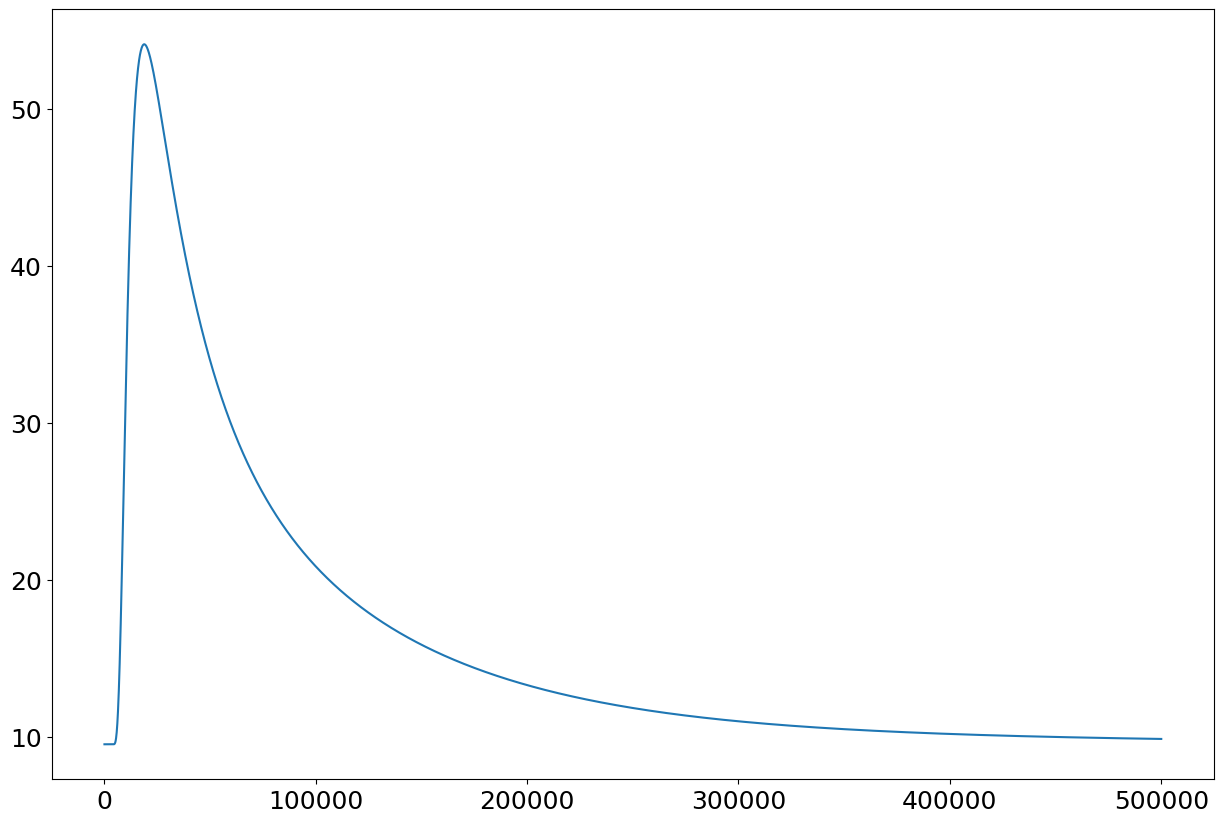

In [31]:
plt.plot(rs, Vs[0, :])